# __Eksploracja danych__
## __Projekt 3: Grupowanie przy użyciu K-means__  
## __Krzysztof Stawarz__  

### 1. PCA dla Patterns

In [1]:
rng(4);

In [2]:
Patterns = cell2mat(struct2cell(load('ed-p03.mat', 'Patterns')));

In [3]:
Patterns = (Patterns - mean(Patterns)) ./ std(Patterns);

In [4]:
cov_matrix = cov(Patterns - mean(Patterns))


cov_matrix =

    1.0000   -0.2393    0.3917   -0.3069
   -0.2393    1.0000   -0.1251    0.1483
    0.3917   -0.1251    1.0000   -0.7320
   -0.3069    0.1483   -0.7320    1.0000



In [5]:
[eigenvectors, eigenvalues] = eig(cov_matrix)


eigenvectors =

   -0.1191    0.8286    0.3004   -0.4572
   -0.0518    0.4456   -0.8554    0.2591
    0.7242   -0.1261   -0.2945   -0.6107
    0.6773    0.3146    0.3023    0.5924


eigenvalues =

    0.2599         0         0         0
         0    0.6952         0         0
         0         0    0.9885         0
         0         0         0    2.0564



In [6]:
[~, sort_indices] = sort(diag(eigenvalues), 'descend');
sorted_eigenvectors = eigenvectors(:,sort_indices);

In [7]:
k_pc = 2;
top_k_eigenvectors = sorted_eigenvectors(:,1:k_pc)


top_k_eigenvectors =

   -0.4572    0.3004
    0.2591   -0.8554
   -0.6107   -0.2945
    0.5924    0.3023



In [8]:
principal_components = Patterns * top_k_eigenvectors;

In [9]:
total_variance = sum(diag(cov_matrix));
variation_pca = 100 * diag(eigenvalues(sort_indices,sort_indices)) / total_variance;

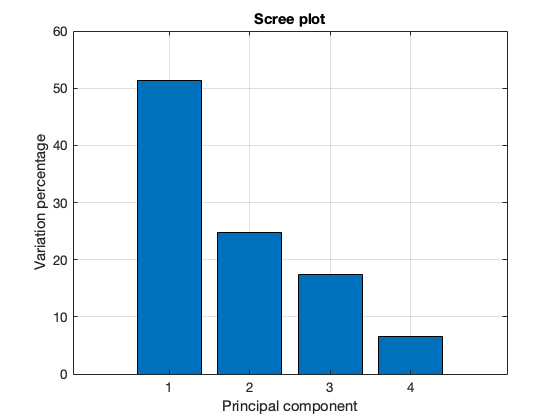

In [10]:
bar([variation_pca(1) variation_pca(2) variation_pca(3) variation_pca(4)]);
xlabel('Principal component');
ylabel('Variation percentage');
title('Scree plot'); grid on;

In [11]:
pc1_plus_pc2_percentage_variation = variation_pca(1) + variation_pca(2)


pc1_plus_pc2_percentage_variation =

   76.1225



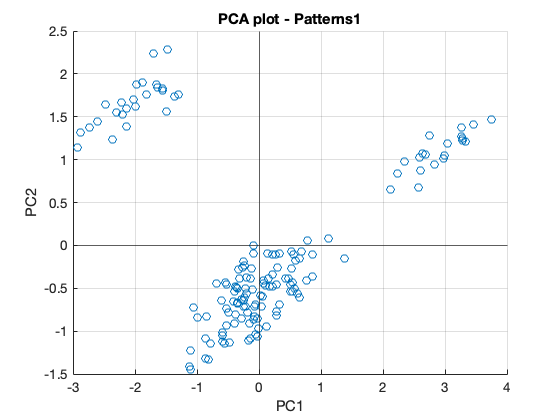

In [12]:
scatter(principal_components(:,1), principal_components(:,2));
grid on;
xline(0);
yline(0);
xlabel('PC1');
ylabel('PC2');
title('PCA plot - Patterns1');

### 2. K-means clustering dla Patterns

#### 2.1 Finding best k using Elbow Method


optimal_k =

     3



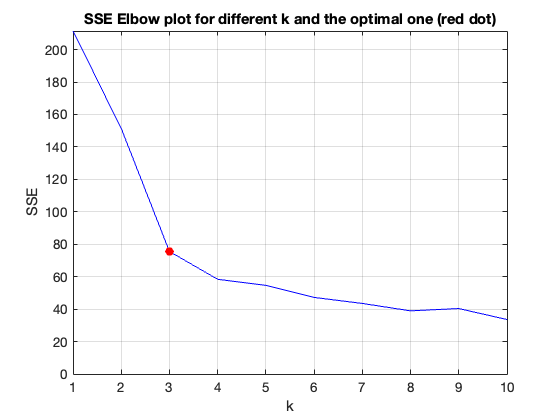

In [13]:
%  setting up relevant variables
max_k = 15;

distance = @(x1, x2, y1, y2) sqrt((x1-x2)^2  + (y1-y2)^2);

sse_4_each_k = [];

%  looping over k's and finding the most optimal one using Elbow method
for k = 1:max_k

    % placing centroids on a 2D plane, making
    centroids = [];

    for j = 1:k 
        random_row = randi(size(principal_components, 1));
        random_centroid = principal_components(random_row, :);
        
        if j~=1
            is_member = ismember(centroids, random_centroid, 'rows');
            
            while any(is_member)
                random_row = randi(size(principal_components, 1));
                random_centroid = principal_components(random_row, :);
                
                is_member = ismember(centroids, random_centroid, 'rows');
            end
        end
        centroids = [centroids; random_centroid];
    end
    
    %  looping and moving centroids untill they all are in equilibrium
    while 1

        %  creating variables to store points nearest to each centroid
        for i = 1:k
            vect_name = sprintf('points_nearest_to_centroid%d', i);
            evalc(sprintf('%s = []', vect_name)); 
        end


        %  calculating nearest cluster for each point
        for i=1:size(principal_components, 1)
            distances = [];

            point_x = principal_components(i, 1);
            point_y = principal_components(i, 2);
            curr_point = [point_x point_y];

            for j=1:k
                temp = distance(point_x, centroids(j, 1), point_y, centroids(j, 2));
                distances = [distances temp];
            end
            
            %  finding nearest centroid
            centroid_index = find(distances == min(distances), 1);

            %  inserting current point to its 'nearest centroid' variable
            evalc(sprintf('points_nearest_to_centroid%d = [points_nearest_to_centroid%d; curr_point]', centroid_index, centroid_index));
        end
        
        %  variable to store all new centroids coords
        new_centroids = [];
        
        %  calculating mean distance from each point to its neares centroid
        for i = 1:k
            if eval(sprintf("isempty(points_nearest_to_centroid%d)", i))
                evalc(sprintf("cluster%d_mean = centroids(%d, :)", i, i));
            else
                evalc(sprintf("cluster%d_mean = [mean(points_nearest_to_centroid%d(:, 1)) mean(points_nearest_to_centroid%d(:,2))]", i, i, i));
            end
        
            %  saving means as new centroids
            evalc(sprintf("new_centroids = [new_centroids; cluster%d_mean]", i));

        end
        
        
        %  checking if any centroid 'moved' since last iteration
        %  if no, they are in their equilibrium, so end the while loop
        if isequal(new_centroids, centroids)
            break;
        end

        %  if they did, switch old centroids with new ones
        centroids = new_centroids;

    end
    
    
    %  calculating Sum of Squared Errors
    sse = 0;
    
    for i = 1:k
    
        centroid = centroids(i, :);
        
        %  if there are no point assosiated with a cluster, dont do any math, just skip it
        if eval(sprintf("isempty(points_nearest_to_centroid%d)", i))
            continue
        end
        
        %  else, caclulate SSE for each point assosiated with a cluster and sum it
        evalc(sprintf("sse = sse + sum(sqrt(sum((centroid - points_nearest_to_centroid%d).^2, 2)))", i));
    
    end
    
    %  append sse for this k to the vector to plot it later
    sse_4_each_k = [sse_4_each_k sse];
end


%  plot SSE
figure(k+1);
plot(1:max_k, sse_4_each_k, 'b-')

%  find optimal k using second derivative
diff_values = diff(sse_4_each_k);
diff2_values = diff(diff_values);

idx = find(diff2_values > 0, 1);

optimal_k = idx + 1

%  highlight the optimal k point in the plot
hold on;
scatter(optimal_k, sse_4_each_k(optimal_k), 'MarkerFaceColor', 'red', 'MarkerEdgeColor', 'red');
xlabel('k');
ylabel('SSE');
ylim([0 max(sse_4_each_k)]);
xlim([1 10]);
grid on;
title("SSE Elbow plot for different k and the optimal one (red dot)");

#### 2.2 Performing K-means on Patterns

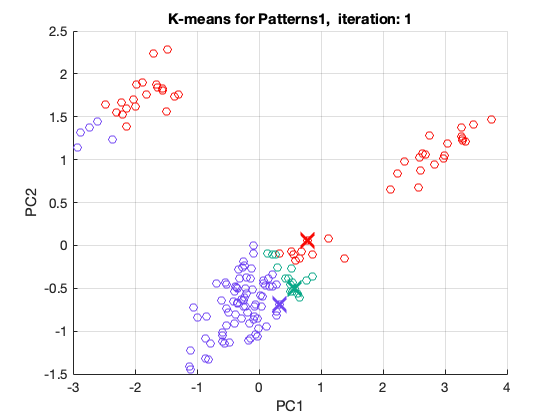

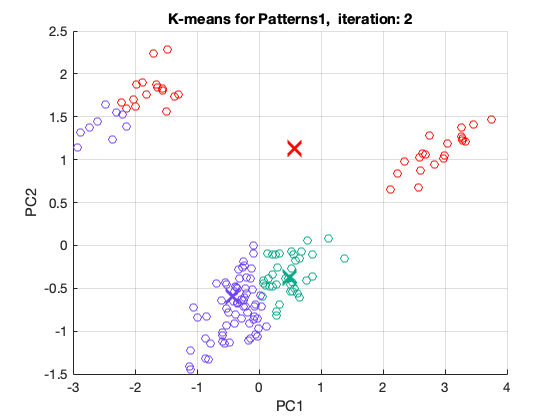

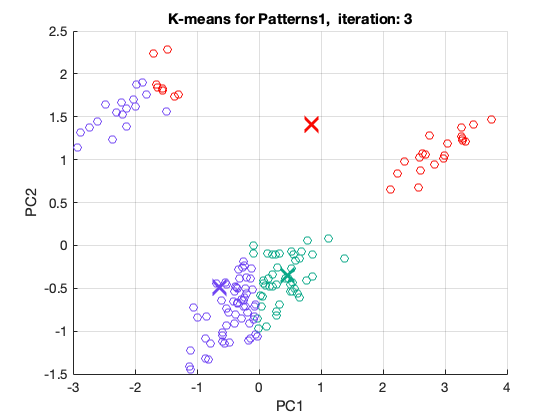

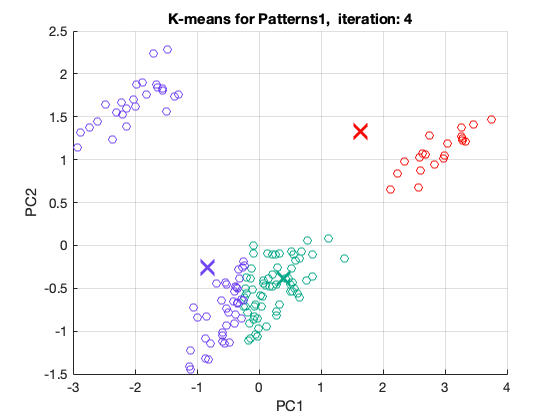

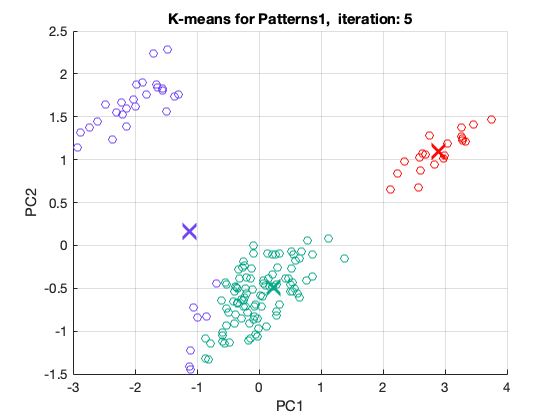

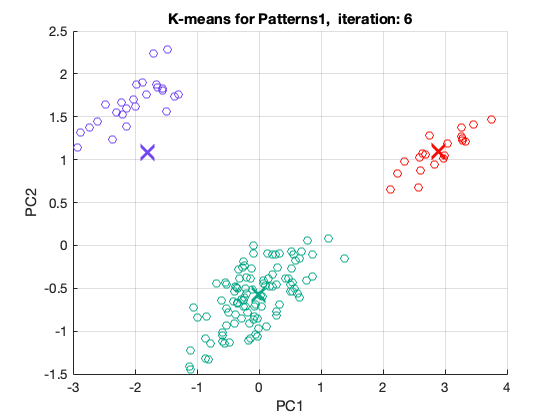

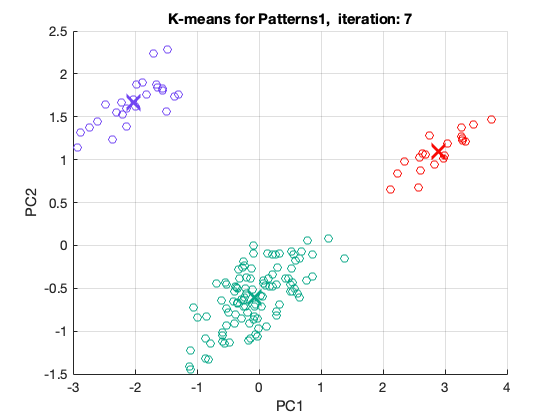

In [14]:
%  clearing unnecessary variables
for f=1:max_k
    evalc(sprintf("clear points_nearest_to_centroid%d", f));
end


k = optimal_k;

%  placing centroids on a 2D plane
centroids = [];
colors = [];

for j = 1:k 
    random_row = randi(size(principal_components, 1));
    random_centroid = principal_components(random_row, :);

    if j~=1
        is_member = ismember(centroids, random_centroid, 'rows');

        while any(is_member)
            random_row = randi(size(principal_components, 1));
            random_centroid = principal_components(random_row, :);

            is_member = ismember(centroids, random_centroid, 'rows');
        end
    end
    centroids = [centroids; random_centroid];
    
    color = rand(1, 3);
    colors = [colors; color];
end

%  looping and moving centroids untill they all are in equilibrium
iteration = 0;
while 1
    
    iteration = iteration + 1;

    %  creating variables to store points nearest to each centroid
    for i = 1:k
        vect_name = sprintf('points_nearest_to_centroid%d', i);
        evalc(sprintf('%s = []', vect_name)); 
    end


    %  calculating nearest cluster for each point
    for i=1:size(principal_components, 1)
        distances = [];

        point_x = principal_components(i, 1);
        point_y = principal_components(i, 2);
        curr_point = [point_x point_y];

        for j=1:k
            temp = distance(point_x, centroids(j, 1), point_y, centroids(j, 2));
            distances = [distances temp];
        end

        %  finding nearest centroid
        centroid_index = find(distances == min(distances));

        %  inserting current point to its 'nearest centroid' variable
        evalc(sprintf('points_nearest_to_centroid%d = [points_nearest_to_centroid%d; curr_point]', centroid_index, centroid_index));
    end
    
    %  plots of every iteration
    figure(iteration)
    for f=1:k
        
        evalc(sprintf("scatter(points_nearest_to_centroid%d(:,1), points_nearest_to_centroid%d(:,2), [], colors(%d, :)); hold on;", f, f, f));
        evalc(sprintf("scatter(centroids(%d, 1), centroids(%d, 2), 200, 'x', 'LineWidth', 3, 'MarkerEdgeColor', colors(%d, :));", f, f, f));
        
        if f~=k
            hold on;
        end
        
    end
    title(sprintf("K-means for Patterns1,  iteration: %d", iteration));
    xlabel('PC1'); ylabel('PC2'); grid on;
    

    %  variable to store all new centroids coords
    new_centroids = [];

    %  calculating mean distance from each point to its neares centroid
    for i = 1:k
        if eval(sprintf("isempty(points_nearest_to_centroid%d)", i))
            evalc(sprintf("cluster%d_mean = centroids(%d, :)", i, i));
        else
            evalc(sprintf("cluster%d_mean = [mean(points_nearest_to_centroid%d(:, 1)) mean(points_nearest_to_centroid%d(:,2))]", i, i, i));
        end

        %  saving means as new centroids
        evalc(sprintf("new_centroids = [new_centroids; cluster%d_mean]", i));

    end


    %  checking if any centroid 'moved' since last iteration
    %  if no, they are in their equilibrium, so end the while loop
    if isequal(new_centroids, centroids)
        break;
    end

    %  if they did, switch old centroids with new ones
    centroids = new_centroids;

end

### 3. PCA dla Patterns2

In [15]:
Patterns2 = cell2mat(struct2cell(load('ed-p03.mat', 'Patterns2')));

In [16]:
Patterns2 = (Patterns2 - mean(Patterns2)) ./ std(Patterns2);

In [17]:
cov_matrix = cov(Patterns2)


cov_matrix =

    1.0000   -0.5947   -0.2762    0.3209
   -0.5947    1.0000    0.2984   -0.2561
   -0.2762    0.2984    1.0000   -0.7709
    0.3209   -0.2561   -0.7709    1.0000



In [18]:
[eigenvectors, eigenvalues] = eig(cov_matrix)


eigenvectors =

   -0.1626    0.6949   -0.5224    0.4667
   -0.1590    0.6819    0.5506   -0.4544
    0.6857    0.1744   -0.4604   -0.5361
    0.6914    0.1473    0.4604    0.5369


eigenvalues =

    0.2189         0         0         0
         0    0.4150         0         0
         0         0    1.1006         0
         0         0         0    2.2654



In [19]:
[~, sort_indices] = sort(diag(eigenvalues), 'descend');
sorted_eigenvectors = eigenvectors(:,sort_indices);

In [20]:
k_pc = 2;
top_k_eigenvectors = sorted_eigenvectors(:,1:k_pc)


top_k_eigenvectors =

    0.4667   -0.5224
   -0.4544    0.5506
   -0.5361   -0.4604
    0.5369    0.4604



In [21]:
principal_components = Patterns2 * top_k_eigenvectors;

In [22]:
total_variance = sum(diag(cov_matrix));
variation_pca = 100 * diag(eigenvalues(sort_indices,sort_indices)) / total_variance;

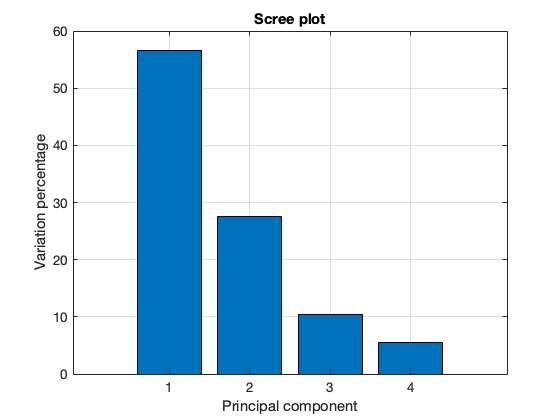

In [23]:
bar([variation_pca(1) variation_pca(2) variation_pca(3) variation_pca(4)]);
xlabel('Principal component');
ylabel('Variation percentage');
title('Scree plot'); grid on;

In [24]:
pc1_plus_pc2_percentage_variation = variation_pca(1) + variation_pca(2)


pc1_plus_pc2_percentage_variation =

   84.1515



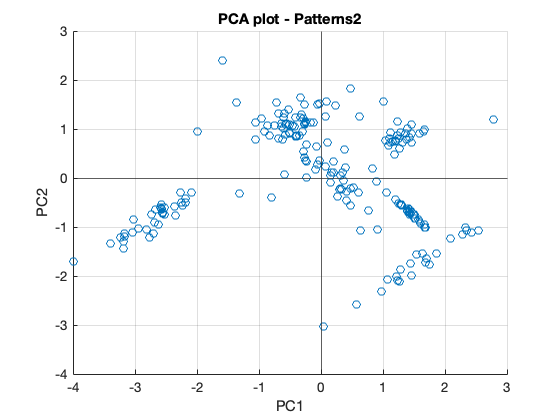

In [25]:
scatter(principal_components(:,1), principal_components(:,2));
xlabel('PC1');
ylabel('PC2');
title('PCA plot - Patterns2'); grid on; xline(0); yline(0);

### 4. K-means clustering dla Patterns2

#### 4.1 Finding best k using Elbow Method


optimal_k =

     3



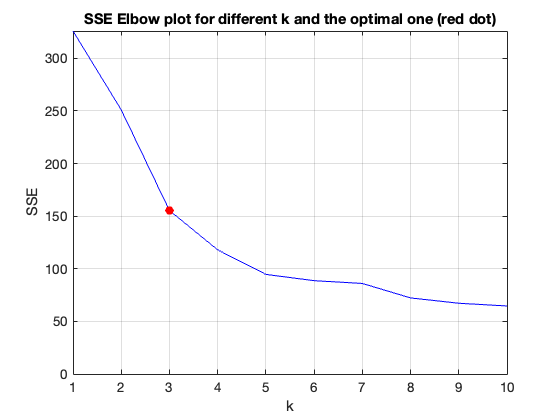

In [26]:
%  setting up relevant variables
max_k = 15;

distance = @(x1, x2, y1, y2) sqrt((x1-x2)^2  + (y1-y2)^2);

sse_4_each_k = [];

%  looping over k's and finding the most optimal one using Elbow method
for k = 1:max_k

    % placing centroids on a 2D plane, making
    centroids = [];

    for j = 1:k 
        random_row = randi(size(principal_components, 1));
        random_centroid = principal_components(random_row, :);
        
        if j~=1
            is_member = ismember(centroids, random_centroid, 'rows');
            
            while any(is_member)
                random_row = randi(size(principal_components, 1));
                random_centroid = principal_components(random_row, :);
                
                is_member = ismember(centroids, random_centroid, 'rows');
            end
        end
        centroids = [centroids; random_centroid];
    end
    
    %  looping and moving centroids untill they all are in equilibrium
    while 1

        %  creating variables to store points nearest to each centroid
        for i = 1:k
            vect_name = sprintf('points_nearest_to_centroid%d', i);
            evalc(sprintf('%s = []', vect_name)); 
        end


        %  calculating nearest cluster for each point
        for i=1:size(principal_components, 1)
            distances = [];

            point_x = principal_components(i, 1);
            point_y = principal_components(i, 2);
            curr_point = [point_x point_y];

            for j=1:k
                temp = distance(point_x, centroids(j, 1), point_y, centroids(j, 2));
                distances = [distances temp];
            end
            
            %  finding nearest centroid
            centroid_index = find(distances == min(distances), 1);

            %  inserting current point to its 'nearest centroid' variable
            evalc(sprintf('points_nearest_to_centroid%d = [points_nearest_to_centroid%d; curr_point]', centroid_index, centroid_index));
        end
        
        %  variable to store all new centroids coords
        new_centroids = [];
        
        %  calculating mean distance from each point to its neares centroid
        for i = 1:k
            if eval(sprintf("isempty(points_nearest_to_centroid%d)", i))
                evalc(sprintf("cluster%d_mean = centroids(%d, :)", i, i));
            else
                evalc(sprintf("cluster%d_mean = [mean(points_nearest_to_centroid%d(:, 1)) mean(points_nearest_to_centroid%d(:,2))]", i, i, i));
            end
        
            %  saving means as new centroids
            evalc(sprintf("new_centroids = [new_centroids; cluster%d_mean]", i));

        end
        
        
        %  checking if any centroid 'moved' since last iteration
        %  if no, they are in their equilibrium, so end the while loop
        if isequal(new_centroids, centroids)
            break;
        end

        %  if they did, switch old centroids with new ones
        centroids = new_centroids;

    end
    
    
    %  calculating Sum of Squared Errors
    sse = 0;
    
    for i = 1:k
    
        centroid = centroids(i, :);
        
        %  if there are no point assosiated with a cluster, dont do any math, just skip it
        if eval(sprintf("isempty(points_nearest_to_centroid%d)", i))
            continue
        end
        
        %  else, caclulate SSE for each point assosiated with a cluster and sum it
        evalc(sprintf("sse = sse + sum(sqrt(sum((centroid - points_nearest_to_centroid%d).^2, 2)))", i));
    
    end
    
    %  append sse for this k to the vector to plot it later
    sse_4_each_k = [sse_4_each_k sse];
end


%  plot SSE
figure(k+1);
plot(1:max_k, sse_4_each_k, 'b-')

%  find optimal k using second derivative
diff_values = diff(sse_4_each_k);
diff2_values = diff(diff_values);

idx = find(diff2_values > 0, 1);

optimal_k = idx + 1

%  highlight the optimal k point in the plot
hold on;
scatter(optimal_k, sse_4_each_k(optimal_k), 'MarkerFaceColor', 'red', 'MarkerEdgeColor', 'red');
xlabel('k');
ylabel('SSE');
ylim([0 max(sse_4_each_k)]);
xlim([1 10]);
grid on;
title("SSE Elbow plot for different k and the optimal one (red dot)");

#### 4.2 Performing K-means on Patterns2

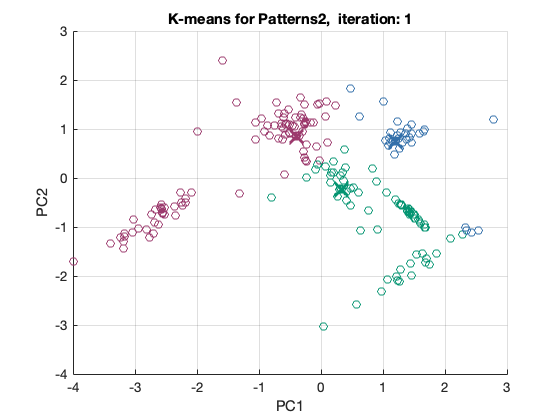

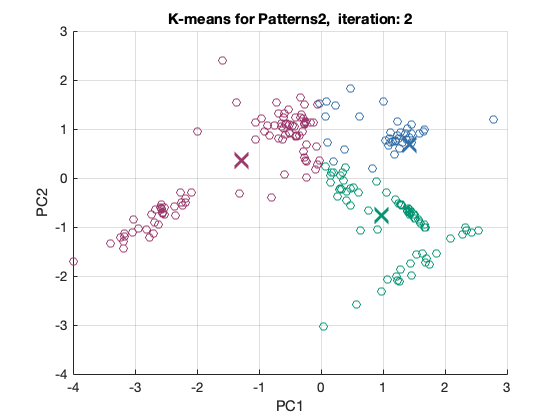

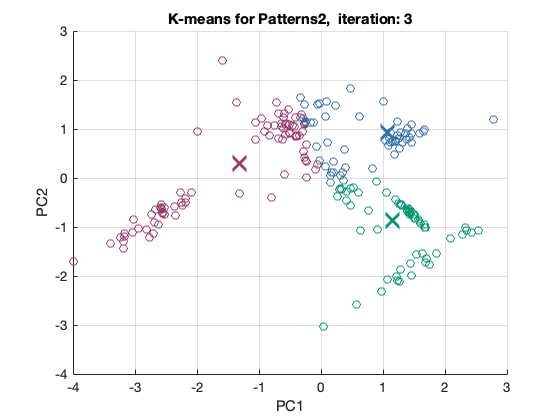

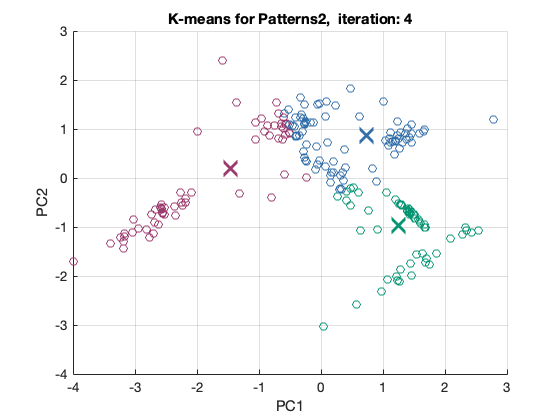

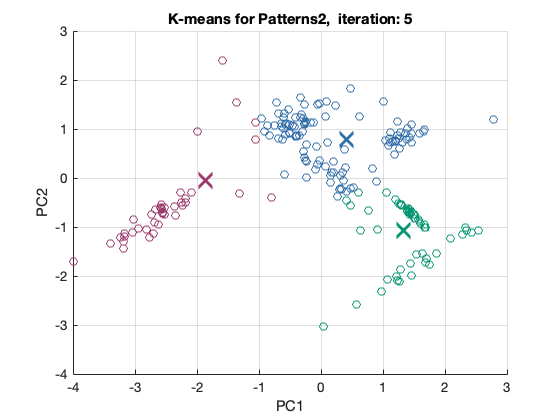

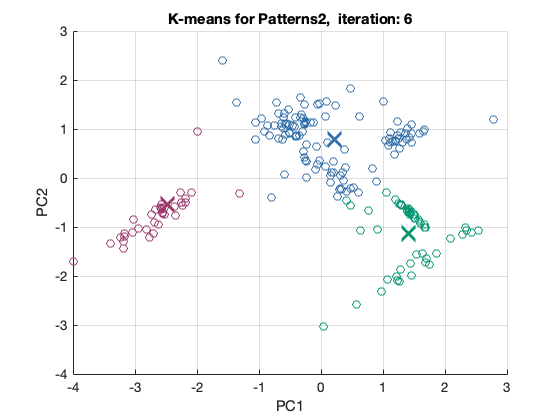

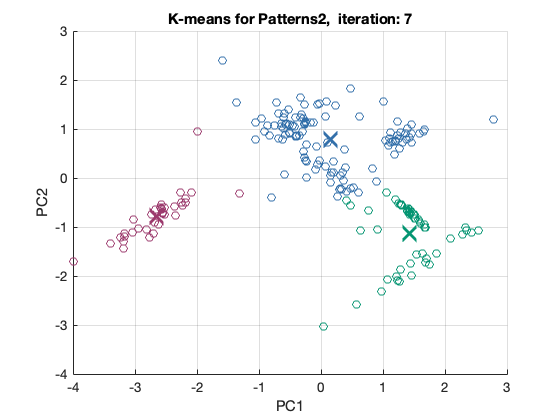

In [27]:
%  clearing unnecessary variables
for f=1:max_k
    evalc(sprintf("clear points_nearest_to_centroid%d", f));
end


k = optimal_k;

%  placing centroids on a 2D plane
centroids = [];
colors = [];

for j = 1:k 
    random_row = randi(size(principal_components, 1));
    random_centroid = principal_components(random_row, :);

    if j~=1
        is_member = ismember(centroids, random_centroid, 'rows');

        while any(is_member)
            random_row = randi(size(principal_components, 1));
            random_centroid = principal_components(random_row, :);

            is_member = ismember(centroids, random_centroid, 'rows');
        end
    end
    centroids = [centroids; random_centroid];
    
    color = rand(1, 3);
    colors = [colors; color];
end

%  looping and moving centroids untill they all are in equilibrium
iteration = 0;
while 1
    
    iteration = iteration + 1;

    %  creating variables to store points nearest to each centroid
    for i = 1:k
        vect_name = sprintf('points_nearest_to_centroid%d', i);
        evalc(sprintf('%s = []', vect_name)); 
    end


    %  calculating nearest cluster for each point
    for i=1:size(principal_components, 1)
        distances = [];

        point_x = principal_components(i, 1);
        point_y = principal_components(i, 2);
        curr_point = [point_x point_y];

        for j=1:k
            temp = distance(point_x, centroids(j, 1), point_y, centroids(j, 2));
            distances = [distances temp];
        end

        %  finding nearest centroid
        centroid_index = find(distances == min(distances));

        %  inserting current point to its 'nearest centroid' variable
        evalc(sprintf('points_nearest_to_centroid%d = [points_nearest_to_centroid%d; curr_point]', centroid_index, centroid_index));
    end
    
    %  plots of every iteration
    figure(iteration)
    for f=1:k
        
        evalc(sprintf("scatter(points_nearest_to_centroid%d(:,1), points_nearest_to_centroid%d(:,2), [], colors(%d, :)); hold on;", f, f, f));
        evalc(sprintf("scatter(centroids(%d, 1), centroids(%d, 2), 200, 'x', 'LineWidth', 3, 'MarkerEdgeColor', colors(%d, :));", f, f, f));
        
        if f~=k
            hold on;
        end
        
    end
    title(sprintf("K-means for Patterns2,  iteration: %d", iteration));
    xlabel('PC1'); ylabel('PC2'); grid on;
    

    %  variable to store all new centroids coords
    new_centroids = [];

    %  calculating mean distance from each point to its neares centroid
    for i = 1:k
        if eval(sprintf("isempty(points_nearest_to_centroid%d)", i))
            evalc(sprintf("cluster%d_mean = centroids(%d, :)", i, i));
        else
            evalc(sprintf("cluster%d_mean = [mean(points_nearest_to_centroid%d(:, 1)) mean(points_nearest_to_centroid%d(:,2))]", i, i, i));
        end

        %  saving means as new centroids
        evalc(sprintf("new_centroids = [new_centroids; cluster%d_mean]", i));

    end


    %  checking if any centroid 'moved' since last iteration
    %  if no, they are in their equilibrium, so end the while loop
    if isequal(new_centroids, centroids)
        break;
    end

    %  if they did, switch old centroids with new ones
    centroids = new_centroids;

end

_Krzysztof Stawarz_  
_Kraków, 26.03.2023_